# Prática: Classificação com Redes Neurais em PyTorch

## Introdução

Este notebook é um exercício prático para a construção, treinamento e avaliação de uma rede neural para um problema de classificação. As células de texto (Markdown) fornecerão o embasamento teórico, e sua tarefa será implementar a lógica correspondente nas células de código subsequentes.

O objetivo é solidificar o entendimento sobre o pipeline de um projeto em PyTorch, desde a manipulação de dados até a avaliação do modelo.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## 1. Geração e Visualização do Dataset

Para que a aplicação de uma rede neural seja justificada, o problema de classificação não deve ser linearmente separável. Utilizaremos o `numpy` para gerar tal dataset.

Para fins de visualização e para aumentar a dimensionalidade, uma terceira feature será artificialmente criada como uma combinação não-linear das duas features originais. Por fim, os dados serão normalizados, o que é uma prática recomendada que auxilia na estabilidade e velocidade do treinamento de redes neurais.

In [2]:
# Geração e preparação do dataset
from sklearn.preprocessing import StandardScaler

def generate_spiral_data(n_samples_per_class=1000, n_turns=3, noise=0.3):
    """
    Gera um dataset de duas espirais 3D entrelaçadas.
    """
    # Geração dos pontos da primeira espiral (Classe 0)
    t = np.linspace(0, n_turns * 2 * np.pi, n_samples_per_class)
    x1 = t * np.cos(t)
    y1 = t * np.sin(t)
    z1 = t

    # Adição de ruído gaussiano
    X1 = np.vstack((x1, y1, z1)).T
    X1 += noise * np.random.randn(*X1.shape)
    y1 = np.zeros(n_samples_per_class)

    # Geração dos pontos da segunda espiral (Classe 1), defasada em 180 graus
    x2 = t * np.cos(t + np.pi)
    y2 = t * np.sin(t + np.pi)
    z2 = t

    # Adição de ruído gaussiano
    X2 = np.vstack((x2, y2, z2)).T
    X2 += noise * np.random.randn(*X2.shape)
    y2 = np.ones(n_samples_per_class)

    # Combinação e embaralhamento dos dados
    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2))

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    y = y[indices]

    return X, y

# Geração dos dados
X, y = generate_spiral_data()

# Normalização dos dados, uma prática padrão
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (labels): {y.shape}")

Shape de X (features): (2000, 3)
Shape de y (labels): (2000,)


### Visualização 3D dos Dados

A visualização do dataset em um espaço tridimensional nos permite obter uma intuição sobre a complexidade da fronteira de decisão que o modelo precisará aprender para separar as classes.

In [3]:
fig = px.scatter_3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    color=y,
    color_continuous_scale=px.colors.qualitative.Vivid,
    title="Dataset Sintético 3D para Classificação"
)
fig.update_traces(marker=dict(size=3))
fig.show()

## 2. Preparação dos Dados para o PyTorch

Nesta seção, você irá encapsular os dados NumPy em classes `Dataset` e `DataLoader` do PyTorch, que são abstrações fundamentais para o carregamento e a iteração sobre os dados de forma eficiente durante o treinamento.

### 2.1. A Classe `Dataset`
É necessário criar uma classe que herde de `torch.utils.data.Dataset`. Esta classe customizada deve implementar três métodos:
- `__init__(self, features, labels)`: O construtor, onde os dados são recebidos. É aqui que os arrays NumPy devem ser convertidos para tensores do PyTorch. As features (X) devem ser do tipo `torch.float32` e os rótulos (y) do tipo `torch.long`.
- `__len__(self)`: Método que retorna o número total de amostras no dataset.
- `__getitem__(self, idx)`: Método que permite o acesso a uma amostra específica do dataset através de um índice `idx`. Ele deve retornar um par `(feature, label)`.

In [4]:
from torch.utils.data import Dataset

# 2.1. A Classe Dataset
# A tarefa aqui é criar uma classe que herde de torch.utils.data.Dataset
# e implemente os três métodos essenciais: __init__, __len__, e __getitem__.

class SpiralDataset(Dataset):
    """Dataset customizado para os dados de espiral 3D."""

    def __init__(self, features, labels):
        """
        Construtor da classe.
        Converte os arrays NumPy de entrada em tensores PyTorch.
        """
        # Converte as features para torch.float32, que é o tipo padrão para dados de entrada.
        self.features = torch.tensor(features, dtype=torch.float32)
        # Converte os rótulos para torch.float32 e ajusta o shape para [N, 1]
        # para ser compatível com a saída do modelo e a BCELoss.
        self.labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        """Retorna o número total de amostras no dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """Retorna uma única amostra (par feature-label) do dataset."""
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

print("Classe SpiralDataset implementada.")

Classe SpiralDataset implementada.


### 2.2. Divisão dos Dados e `DataLoader`
Com a classe `Dataset` definida, o próximo passo é:
1.  Dividir os arrays `X` e `y` em conjuntos de treinamento e teste utilizando `train_test_split`.
2.  Instanciar a sua classe Dataset para cada um desses conjuntos.
3.  Criar instâncias de `DataLoader` para os dois datasets. O `DataLoader` é um iterador que agrupa os dados em mini-lotes (`mini-batches`), com a opção de embaralhá-los a cada época, uma prática essencial para o conjunto de treino.

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# 2.2. Divisão dos Dados e DataLoader

# 1. Dividir os arrays X e y em conjuntos de treinamento e teste.
# Usaremos 80% dos dados para treino e 20% para teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Instanciar a classe Dataset para cada conjunto.
train_dataset = SpiralDataset(X_train, y_train)
test_dataset = SpiralDataset(X_test, y_test)

# 3. Criar instâncias de DataLoader.
# O batch_size define quantas amostras serão processadas por vez.
batch_size = 32
# shuffle=True é importante para o treino para que o modelo não aprenda a ordem dos dados.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Para o teste, o embaralhamento não é necessário.
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("Dados divididos e DataLoaders criados com sucesso.")
print(f"Tamanho do lote (batch size): {batch_size}")
print(f"Número de lotes no train_loader: {len(train_loader)}")
print(f"Número de lotes no test_loader: {len(test_loader)}")

Dados divididos e DataLoaders criados com sucesso.
Tamanho do lote (batch size): 32
Número de lotes no train_loader: 50
Número de lotes no test_loader: 13


## 3. Arquitetura da Rede Neural

A arquitetura do modelo será composta por camadas ocultas e uma camada de saída.
- As camadas ocultas são responsáveis por aprender representações complexas dos dados e podem ser construídas com `nn.Linear` e `nn.ReLU`.
- A **camada de saída** deve ter **apenas 1 neurônio**.
- Após a última camada linear, deve ser aplicada uma função de ativação `nn.Sigmoid()`.

A saída do modelo será um único valor entre 0 e 1 para cada amostra de entrada, que pode ser interpretado como a probabilidade da amostra pertencer à classe 1.
$$ \hat{y} = \sigma(W_{\text{out}} \cdot a_{\text{hidden}} + b_{\text{out}}) $$
Onde $a_{\text{hidden}}$ é a ativação da última camada oculta e $\sigma$ é a função Sigmoid.

In [6]:
import torch.nn as nn

# 3. Arquitetura da Rede Neural
# Criaremos um MLP com uma camada oculta.
# Entrada (3 features) -> Camada Oculta (Linear + ReLU) -> Saída (Linear + Sigmoid)

class MLPClassifier(nn.Module):
    def __init__(self, input_features, hidden_features, out_features):
        super(MLPClassifier, self).__init__()
        # Camada oculta: recebe 3 features e transforma em 'hidden_features'
        self.hidden_layer = nn.Linear(input_features, hidden_features)
        # Função de ativação não-linear
        self.relu = nn.ReLU()
        # Camada de saída: recebe 'hidden_features' e retorna 1 valor
        self.output_layer = nn.Linear(hidden_features, out_features)
        # Função de ativação de saída para obter uma probabilidade
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Define o fluxo dos dados através da rede
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

# Instancia o modelo
# Usaremos 3 features de entrada, 16 neurônios na camada oculta e 1 na saída.
model = MLPClassifier(input_features=3, hidden_features=16, out_features=1)

# Imprime a arquitetura do modelo
print("Arquitetura da Rede Neural:")
print(model)

Arquitetura da Rede Neural:
MLPClassifier(
  (hidden_layer): Linear(in_features=3, out_features=16, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## 4. Função de Custo e Otimizador

A **função de custo** para este problema será a `nn.BCELoss` (*Binary Cross-Entropy Loss*). Esta função mede o erro entre a probabilidade prevista pelo modelo e o rótulo verdadeiro (0 ou 1), sendo a escolha canônica para classificação binária.

Para o **otimizador**, utilizaremos o `torch.optim.SGD`, que implementa o algoritmo de descida do gradiente estocástico. Sua principal configuração é a **taxa de aprendizado** (`learning_rate`).

In [7]:
# 4. Função de Custo e Otimizador

# Definindo os hiperparâmetros
learning_rate = 0.01

# A função de custo para classificação binária é a Binary Cross-Entropy Loss.
loss_fn = nn.BCELoss()

# O otimizador será o Stochastic Gradient Descent (SGD).
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f"Função de Custo: {loss_fn}")
print(f"Otimizador: SGD com learning rate = {learning_rate}")

Função de Custo: BCELoss()
Otimizador: SGD com learning rate = 0.01


## 5. Loop de Treinamento

O loop de treinamento segue uma estrutura de 5 passos, iterando sobre os dados por um número definido de épocas. Para cada lote de dados, o ciclo é:

1.  **Forward Pass**: Propagar os dados de entrada pelo modelo para obter as predições.
2.  **Cálculo da Perda**: Calcular a perda comparando as predições com os rótulos verdadeiros.
3.  **Zerar Gradientes**: Limpar os gradientes da iteração anterior (`optimizer.zero_grad()`).
4.  **Backward Pass (Backpropagation)**: Calcular os gradientes da perda em relação a cada parâmetro (`loss.backward()`).
5.  **Atualização dos Pesos**: Atualizar os pesos do modelo usando o otimizador (`optimizer.step()`).

In [8]:
# 5. Loop de Treinamento
# Implementação do ciclo completo de treinamento e validação.

num_epochs = 100
train_losses = []
train_accuracies = []

print("Iniciando o loop de treinamento...")

for epoch in range(num_epochs):
    model.train() # Coloca o modelo em modo de treinamento

    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    for features, labels in train_loader:
        # 1. Forward Pass
        outputs = model(features)

        # 2. Cálculo da Perda
        loss = loss_fn(outputs, labels)

        # 3. Zerar Gradientes
        optimizer.zero_grad()

        # 4. Backward Pass
        loss.backward()

        # 5. Atualização dos Pesos
        optimizer.step()

        # Acumula a perda e calcula a acurácia para a época
        epoch_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Armazena as métricas da época
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Perda: {avg_train_loss:.4f}, Acurácia: {avg_train_acc:.2f}%')

print("\nTreinamento concluído!")

Iniciando o loop de treinamento...
Época [10/100], Perda: 0.6865, Acurácia: 53.62%
Época [20/100], Perda: 0.6838, Acurácia: 52.19%
Época [30/100], Perda: 0.6819, Acurácia: 53.06%
Época [40/100], Perda: 0.6805, Acurácia: 53.12%
Época [50/100], Perda: 0.6795, Acurácia: 52.69%
Época [60/100], Perda: 0.6786, Acurácia: 52.88%
Época [70/100], Perda: 0.6779, Acurácia: 52.38%
Época [80/100], Perda: 0.6770, Acurácia: 52.19%
Época [90/100], Perda: 0.6762, Acurácia: 53.50%
Época [100/100], Perda: 0.6753, Acurácia: 55.00%

Treinamento concluído!


## 6. Visualização e Avaliação do Desempenho

### Curvas de Aprendizagem
Após o treinamento, é fundamental analisar as curvas de aprendizagem. A plotagem da perda e da acurácia ao longo das épocas nos permite diagnosticar se o modelo aprendeu corretamente e se há sinais de problemas como *overfitting* ou *underfitting*.

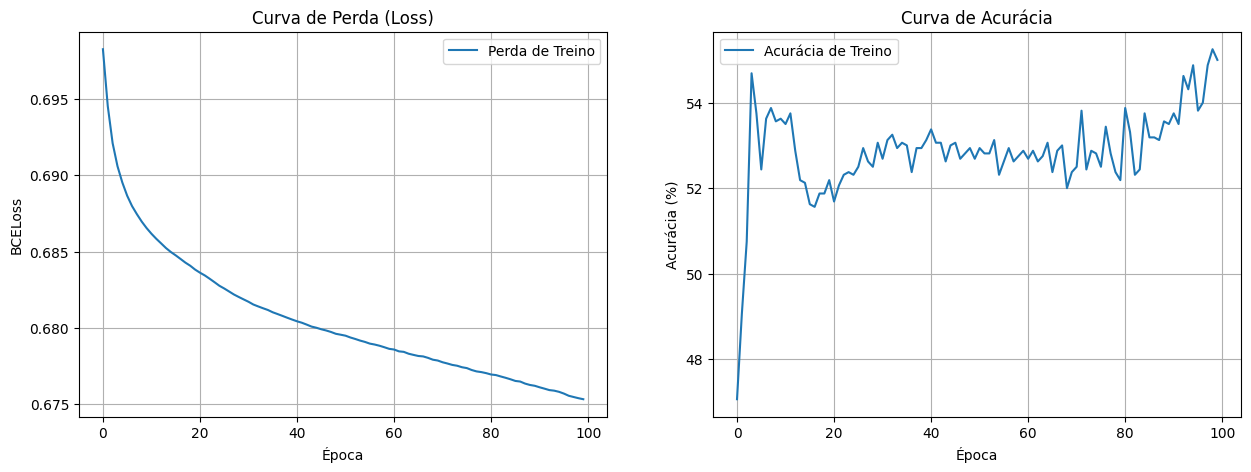

In [9]:
# --- 6.1 Curvas de Aprendizagem ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot da curva de perda
ax1.plot(train_losses, label='Perda de Treino')
ax1.set_title("Curva de Perda (Loss)")
ax1.set_xlabel("Época")
ax1.set_ylabel("BCELoss")
ax1.grid(True)
ax1.legend()

# Plot da curva de acurácia
ax2.plot(train_accuracies, label='Acurácia de Treino')
ax2.set_title("Curva de Acurácia")
ax2.set_xlabel("Época")
ax2.set_ylabel("Acurácia (%)")
ax2.grid(True)
ax2.legend()

plt.show()

### Avaliação Final no Conjunto de Teste
A avaliação final deve ser feita no conjunto de teste, que o modelo não viu durante o treinamento. Isso fornece uma estimativa imparcial de sua capacidade de generalização.

Para a fase de avaliação (inferência), é importante colocar o modelo em modo de avaliação com `model.eval()` e realizar os cálculos dentro de um bloco `with torch.no_grad()` para desativar o cálculo de gradientes.

In [10]:
# --- 6.2 Avaliação Final no Conjunto de Teste ---
model.eval() # Coloca o modelo em modo de avaliação
with torch.no_grad(): # Desabilita o cálculo de gradientes

    all_labels = []
    all_predicted = []

    for features, labels in test_loader:
        outputs = model(features)
        predicted = (outputs > 0.5).float()

        all_labels.extend(labels.numpy())
        all_predicted.extend(predicted.numpy())

    all_labels = np.array(all_labels).flatten()
    all_predicted = np.array(all_predicted).flatten()

# Calcula a acurácia final no conjunto de teste
accuracy_final = 100 * (all_labels == all_predicted).sum() / len(all_labels)
print(f'\nAcurácia final no conjunto de teste: {accuracy_final:.2f} %')


Acurácia final no conjunto de teste: 53.25 %


In [11]:
# --- Plot 3D das Predições no Conjunto de Teste ---
fig = px.scatter_3d(
    x=X_test[:, 0],
    y=X_test[:, 1],
    z=X_test[:, 2],
    color=all_predicted, # Cor baseada nas PREDIÇÕES do modelo
    color_continuous_scale=px.colors.qualitative.Vivid,
    title="Predições do Modelo no Conjunto de Teste"
)
fig.update_traces(marker=dict(size=3))
fig.show()